In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
if sys.version_info >= (3,8):
    import pickle
else:
    !pip install pickle5
    import pickle5 as pickle
import os

Mounted at /content/drive


In [5]:
import numpy as np
os.listdir('/content/drive/My Drive/')
# data accessible at:
# https://drive.google.com/drive/folders/1Q9t79aCPfy3l0N7udN3ngR1L52XYyFgu?usp=sharing 
# data made with:
# https://github.com/maximoskp/MSc_MTA_HMU_AppliedML/tree/main/c06_audio_AE 
with open('/content/drive/My Drive/Colab_Files/tiny_SOL_all.pickle', 'rb') as f:
    tiny_SOL_all = pickle.load( f )

# prepare data
d = {}
for k in list(tiny_SOL_all.keys()):
    d[k] = np.array( tiny_SOL_all[k] )
print('keys: ', list( d.keys() ))
print('shape: ', d['Strings'][0].shape)

keys:  ['Strings', 'Keyboards', 'Brass', 'Winds']
shape:  (8000,)


In [6]:
import tensorflow as tf
from tensorflow import keras

In [12]:
max_norm_value = 2.0
input_shape = [8000,1]

latent_size = 300

# number of parameters per layer
# https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d

# create the model
encoder = keras.models.Sequential(name='encoder')
encoder.add(keras.layers.Conv1D(16, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
encoder.add(keras.layers.MaxPooling1D(2))
encoder.add(keras.layers.Conv1D(32, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
encoder.add(keras.layers.MaxPooling1D(2))
encoder.add(keras.layers.Conv1D(64, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
encoder.add(keras.layers.MaxPooling1D(2))
encoder.add(keras.layers.Conv1D(2, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
encoder.add(keras.layers.Flatten())

latent = keras.models.Sequential([
    keras.layers.Dense(latent_size)
],name='latent')

# dec_in = 7996 # without upsampling
dec_in = 1997

decoder = keras.models.Sequential(name='decoder')
decoder.add(keras.layers.Dense(dec_in, activation='tanh'))
decoder.add(keras.layers.Reshape( (dec_in,1) ))
decoder.add(keras.layers.Conv1DTranspose(64, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
decoder.add(keras.layers.UpSampling1D(2))
decoder.add(keras.layers.Conv1DTranspose(32, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', kernel_initializer='he_uniform'))
decoder.add(keras.layers.UpSampling1D(2))
decoder.add(keras.layers.Conv1DTranspose(16, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', padding='same', kernel_initializer='he_uniform'))
decoder.add(keras.layers.Conv1DTranspose(16, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='relu', padding='same', kernel_initializer='he_uniform'))
decoder.add(keras.layers.Conv1D(1, kernel_size=3, kernel_constraint=keras.constraints.max_norm(max_norm_value), activation='tanh', padding='same'))

model = keras.models.Sequential([encoder, latent, decoder], name='vae')
# model = keras.models.Sequential([encoder, latent])

encoder.summary()
latent.summary()
decoder.summary()
model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 7998, 16)          64        
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 3999, 16)         0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 3997, 32)          1568      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 1998, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, 1996, 64)          6208      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 998, 64)          0   

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
x_train = np.r_[ d['Brass'], d['Strings'], d['Winds'], d['Keyboards'] ]

history = model.fit( x_train , x_train, epochs=100)

Epoch 1/100
92/92 [==============================] - 103s 1s/step - loss: 0.0017
Epoch 2/100
44/92 [=============>................] - ETA: 52s - loss: 0.0018

KeyboardInterrupt: ignored

In [ ]:
encoder.save('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_encoder.keras')
latent.save('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_latent.keras')
decoder.save('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_decoder.keras')
model.save('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_vae.keras')

In [ ]:
encoder = tf.keras.models.load_model('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_encoder.keras')
discriminator = tf.keras.models.load_model('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_latent.keras')
gan = tf.keras.models.load_model('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_decoder.keras')
gan = tf.keras.models.load_model('/content/drive/My Drive/MSc_MTA_AML/class08/models/vae_sol_conv1d_vae.keras')

In [16]:
y = model.predict(d['Strings'])

38/38 [==============================] - 15s 366ms/step


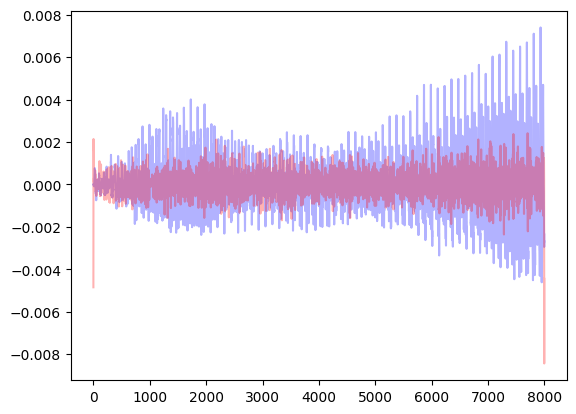

In [17]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(d['Strings'][0], 'b', alpha=0.3)
plt.plot(y[0,:], 'r', alpha=0.3)
plt.show()

In [18]:
import IPython
# original
s = d['Strings'][2]
IPython.display.Audio(s, rate=8000, autoplay=True)

In [19]:
# synthesized
s = np.reshape( y[2,:], 8000 )
IPython.display.Audio(s, rate=8000, autoplay=True)

In [20]:
random_input = np.random.rand(1, latent_size)
r = decoder.predict( random_input )
IPython.display.Audio(r[0,:,0], rate=8000, autoplay=True)

1/1 [==============================] - 1s 1s/step
